In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from copy import deepcopy

# Downloading dataset

In [2]:
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test = load_dataset('Falah/Alzheimer_MRI', split='test')

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

# Extracting data from json file

In [3]:
images = []
labels = []

for i in dataset:
    images += [np.array(i["image"])]
    labels += [i["label"]]
    
images = np.array(images)
labels = np.array(labels)

# Preprocessing pipeline and splitting the batch

In [4]:
class PreProcess(Dataset):
    def __init__(self, images, labels, transform):
        super(PreProcess, self).__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, x):
        img, label = self.images[x], self.labels[x]
        img = self.transform(img.reshape(img.shape[0], img.shape[1], 1))
        
        
        return img, label

In [6]:
IMG_SIZE = 224

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.5],
                                                   std=[0.5])])

In [7]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, random_state=42, test_size=0.2)

# Training hyper-parameters

In [8]:
EPOCHS = 20
LR = 0.1
GAMMA = 0.1
STEP = 10
BATCH = 128
OUT_SIZE = 4

# Creating the dataset and dataloader iterators

In [9]:
train_ds = PreProcess(train_images, train_labels, transform)
val_ds = PreProcess(val_images, val_labels, transform)

In [10]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

# Classification model with skip connections

In [13]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, OUT_SIZE)

In [14]:
class AlzheimerClassifier(nn.Module):
    def __init__(self, model):
        super(AlzheimerClassifier, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1),
                                  nn.BatchNorm2d(3),
                                  nn.ReLU())
        
        self.model = model
        
    def forward(self, x):
        x = self.conv(x)
        x = self.model(x)
        
        return nn.functional.softmax(x, dim=1)

# Training device

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Model training parameters

In [16]:
model = AlzheimerClassifier(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# Training loop

In [17]:
best_mode = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    
    diff = 0
    acc = 0
    total = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        
        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    
    diff = 0
    acc = 0
    total = 0
    with torch.no_grad():
        for data, target in val_dl:

            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] >= best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    print("Epoch {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1], train_acc[-1],
                                                                   val_loss[-1], val_acc[-1]))
    scheduler.step()

Epoch 1 train loss 0.009548677917337045 acc 0.505126953125 val loss 0.009229111252352595 acc 0.5263671875
Epoch 2 train loss 0.008821006456855685 acc 0.620361328125 val loss 0.00873297464568168 acc 0.634765625
Epoch 3 train loss 0.008294018000015058 acc 0.6923828125 val loss 0.008427028893493116 acc 0.65234375
Epoch 4 train loss 0.007798611171892844 acc 0.751953125 val loss 0.00840033870190382 acc 0.662109375
Epoch 5 train loss 0.007356510206591338 acc 0.8046875 val loss 0.007972996914759278 acc 0.7275390625
Epoch 6 train loss 0.007153126993216574 acc 0.824462890625 val loss 0.007537963043432683 acc 0.783203125
Epoch 7 train loss 0.006998619413934648 acc 0.8369140625 val loss 0.0077803784515708685 acc 0.73828125
Epoch 8 train loss 0.006773870540200733 acc 0.883544921875 val loss 0.007482713379431516 acc 0.796875
Epoch 9 train loss 0.006449695094488561 acc 0.935302734375 val loss 0.007122927461750805 acc 0.841796875
Epoch 10 train loss 0.0061744669219478965 acc 0.9638671875 val loss 0.0

# Training performance log

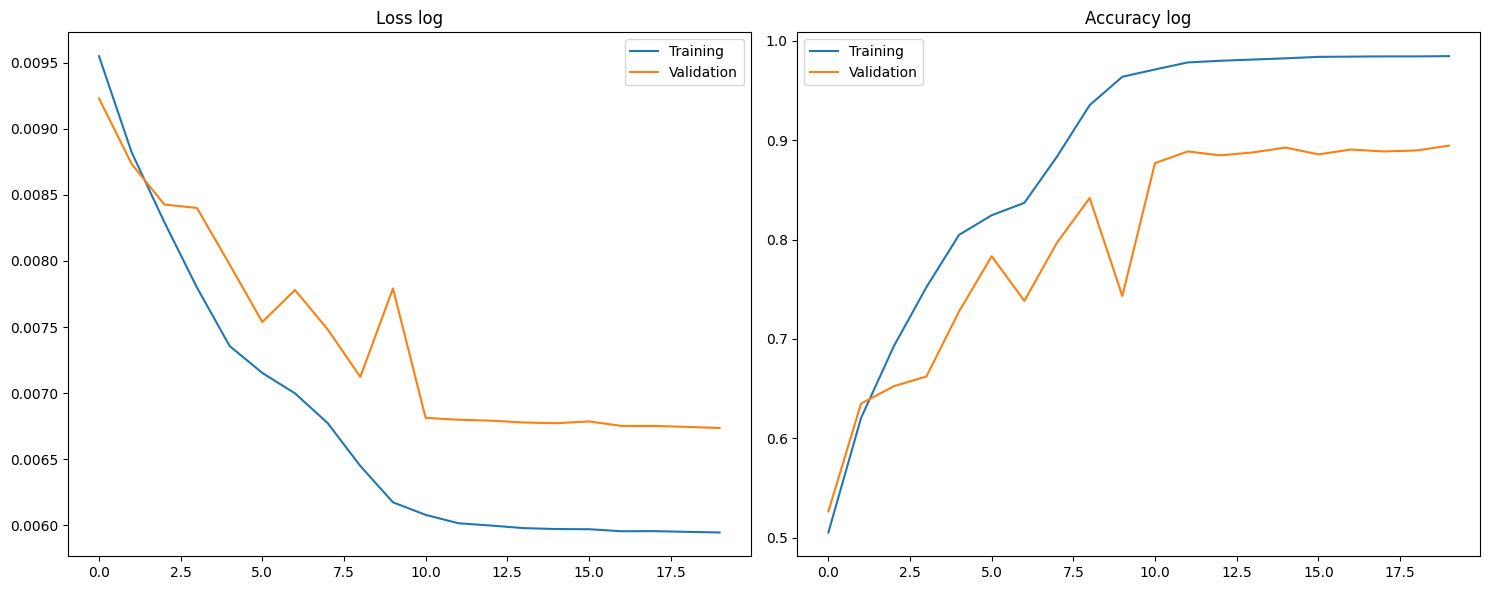

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

axes[index].plot(train_loss, label="Training")
axes[index].plot(val_loss, label="Validation")
axes[index].legend()
axes[index].set_title("Loss log")

index += 1

axes[index].plot(train_acc, label="Training")
axes[index].plot(val_acc, label="Validation")
axes[index].legend()
axes[index].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [22]:
def predict(img):
    img = transform(img).view(1, 1, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        out = model(img)
        
    index = out.argmax(1).item()
    return index, out.cpu().detach().numpy()[0][index]

# Mapping pipeline

In [20]:
index_label = {0: "Mild Demented",
1: "Moderate Demented",
2: "Non Demented",
3: "Very Mild Demented"}

# Predicting test values

In [23]:
pred = []
proba = []
truth = []

for i in test:
    index, conf = predict(np.array(i["image"]))
    pred += [index]
    proba += [conf]
    truth += [i["label"]]

# Test values evaluation

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       188
           1       0.00      0.00      0.00         0
           2       0.93      0.90      0.91       654
           3       0.83      0.87      0.85       438

    accuracy                           0.86      1280
   macro avg       0.63      0.62      0.62      1280
weighted avg       0.87      0.86      0.86      1280



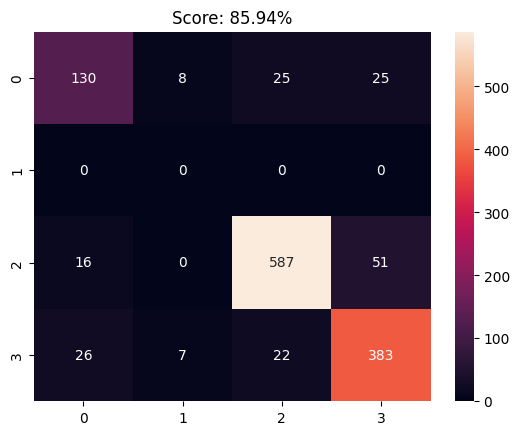

In [24]:
score = accuracy_score(pred, truth)
cm = confusion_matrix(pred, truth)
report = classification_report(pred, truth)
print(report)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Score: {}%".format(round(score*100, 2)))
plt.show()

# Visual inspection of results with confidence scores

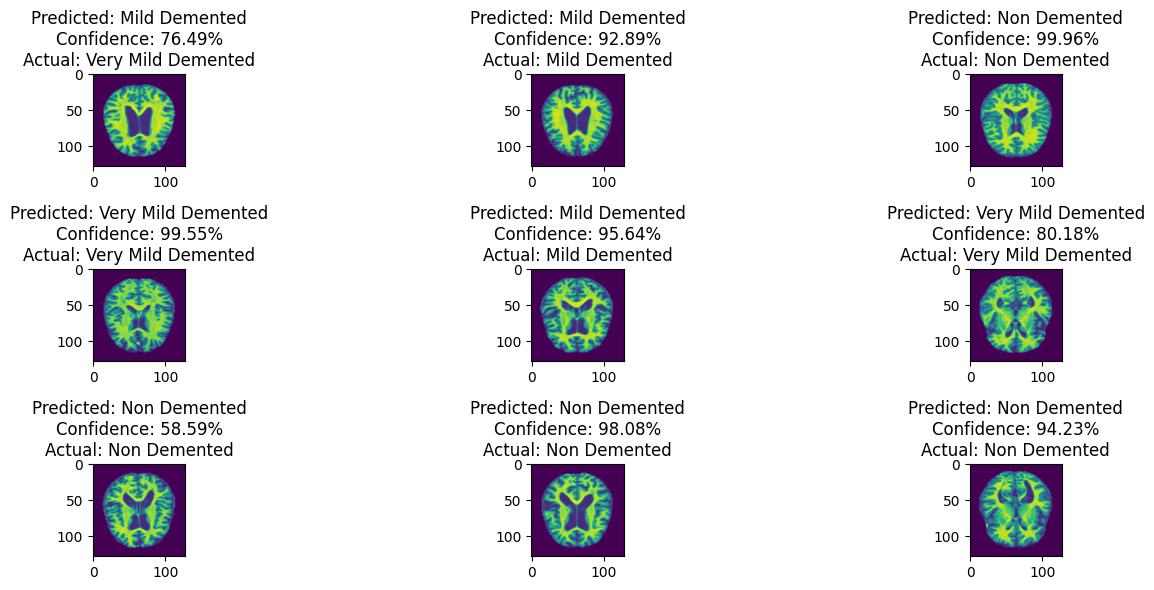

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))
index = 0

for i in range(3):
    for j in range(3):
        axes[i][j].imshow(np.array(test[index]["image"]))
        axes[i][j].set_title("Predicted: {}\nConfidence: {}%\nActual: {}".format(index_label[pred[index]],
                                                                             round(proba[index]*100, 2),
                                                                             index_label[truth[index]]))
        index += 1
plt.tight_layout()
plt.show()